In [1]:
!pip install transformers[torch]==4.19.2 -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import random
plt.rcParams["figure.dpi"] = 150

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cuda


In [4]:
# Input

# Trained Model
distilbert_model = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'

# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_input_unprocessed.pkl'
date_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_marks_date.csv'


# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# Output probabilities
prob_out_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_mark_date_probs.csv'


Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# Read modeling data
df = pd.read_pickle(data_path)
df['filing_dt'] = pd.to_datetime(df['filing_dt'])
print("Modeling data shape: ", df.shape)

# Read dates data
df_dates = pd.read_csv(date_path)
df_merged = df[['serial_no','mark_unprocessed','bert_input_unprocessed','distinct_ind']].merge(df_dates, on=['serial_no'], how = 'inner')
print("Merged data shape: ", df_merged.shape)


Modeling data shape:  (1501358, 22)


<ipython-input-5-911529b7d10b>:7: DtypeWarning: Columns (3,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dates = pd.read_csv(date_path)


Merged data shape:  (1501358, 22)


In [ ]:
# Check null values for date
# Cols that might be useful: abandon_dt, filing_dt, file_location_dt, publication_dt, registration_dt, cfh_status_dt
print(df_merged.isnull().sum())
df_merged.drop(columns=['amend_reg_dt','reg_cancel_dt','renewal_dt','repub_12c_dt','repub_12c_dt',
                        'ir_auto_reg_dt','ir_death_dt','ir_publication_dt','ir_registration_dt',
                        'ir_renewal_dt','ir_status_dt','ir_priority_dt'], inplace=True)
df_merged.head()

serial_no                       0
mark_unprocessed                0
bert_input_unprocessed          0
distinct_ind                    0
mark_id_char                    0
abandon_dt                 963960
amend_reg_dt              1443824
reg_cancel_dt             1434539
filing_dt                       0
file_location_dt                1
publication_dt             376667
registration_dt            618130
renewal_dt                1501358
repub_12c_dt              1501358
cfh_status_dt                   0
ir_auto_reg_dt            1459496
ir_death_dt               1500265
ir_publication_dt         1459496
ir_registration_dt        1459496
ir_renewal_dt             1459496
ir_status_dt              1459496
ir_priority_dt            1478390
dtype: int64


,serial_no,mark_unprocessed,bert_input_unprocessed,distinct_ind,mark_id_char,abandon_dt,filing_dt,file_location_dt,publication_dt,registration_dt,cfh_status_dt
0,85507018,RODOPTICS,"[CLS] RODOPTICS [SEP] Eyeglasses; Eyewear, nam...",1,RODOPTICS,NaN,2012-01-01,2012-08-14,2012-05-29,2012-08-14,2019-03-15
1,85507042,TRIVEDI WINE,[CLS] TRIVEDI WINE [SEP] Intent to use descrip...,0,TRIVEDI WINE,2013-04-26,2012-01-01,2013-05-24,NaN,NaN,2013-05-24
2,85507043,101 GLASSES,"[CLS] 101 GLASSES [SEP] ""GLASSES"" Eyewear, nam...",1,101 GLASSES,NaN,2012-01-01,2016-02-10,2013-01-08,2016-03-15,2016-03-15
3,85507044,MILLIONAIRE TREASURE HUNT,[CLS] MILLIONAIRE TREASURE HUNT [SEP] Entertai...,1,MILLIONAIRE TREASURE HUNT,2013-02-25,2012-01-01,2012-07-24,2012-05-29,NaN,2013-02-25
4,85507045,"STONE, WIND AND VINES","[CLS] STONE, WIND AND VINES [SEP] Wine [SEP] n...",1,"STONE, WIND AND VINES",2013-08-26,2012-01-01,2012-12-20,2012-05-29,NaN,2013-08-26


In [ ]:
# Get train, validation and test set
df_merged['filing_dt'] = pd.to_datetime(df_merged['filing_dt'])

# Divide data into train, test and validation
df_train = df_merged[(df_merged['filing_dt']>=pd.to_datetime('2012-01-01')) & (df_merged['filing_dt']<=pd.to_datetime('2017-12-31'))]
df_val = df_merged[(df_merged['filing_dt']>=pd.to_datetime('2018-01-01')) & (df_merged['filing_dt']<=pd.to_datetime('2018-12-31'))]
df_test = df_merged[(df['filing_dt']>=pd.to_datetime('2019-01-01')) & (df_merged['filing_dt']<=pd.to_datetime('2019-12-31'))]
print("Train data shape: ", df_train.shape)
print("Validation data shape: ", df_val.shape)
print("Test data shape: ", df_test.shape)


Train data shape:  (1001779, 11)
Validation data shape:  (234752, 11)
Test data shape:  (264827, 11)


In [ ]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [ ]:
# X_test
X_test = np.array(df_test['bert_input_unprocessed'])
# y_test
y_test = np.array(df_test['distinct_ind'])


batch_size = 16
# Batching
test_max_idx = batch_size * (len(X_test)//batch_size)
X_test = batching(X_test, test_max_idx, batch_size=16)
y_test = batching(y_test, test_max_idx, batch_size=16)

In [ ]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [ ]:
# Function for predicting y
def bert_pred(model_path, X, y, tokenizer, th=0.5, temp=None):
    loaded_model = torch.load(model_path)
    predictions, targets = [], []
    pred_prob = []
    loaded_model.eval()
    with torch.no_grad():
        for text, labels in tqdm(zip(X, y), total=len(X)):
            #try:
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = loaded_model(**model_inputs)
            logits = output[0]
            if temp is not None:
                logits = T_scaling(logits, {'temperature':temp})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
            if th==0.5:
                # prediction is the argmax of the logits
                predictions.extend(logits.argmax(dim=1).tolist())
            else:
                predictions.extend(((probs[:,1]>=th)*1).tolist())
            targets.extend(labels)
            #except:
            #    print("Unable to process: ", text)
            #    continue
    return targets, pred_prob, predictions

In [ ]:
# Get probabilities
labels, pred_prob, predictions = bert_pred(distilbert_model, X_test, y_test, tokenizer, temp=0.75)
df_test_copy = df_test[:264816].copy()
df_test_copy['pred_prob'] = pred_prob

# Save dataframe
df_test_copy.to_csv(prob_out_path, index=False)

In [ ]:
from google.colab import runtime
runtime.unassign()


### Load data, make plots

In [5]:
import seaborn as sns

In [6]:
# Read data with probabilities
df_probs = pd.read_csv(prob_out_path)

# Convert to datetime
df_probs['filing_dt'] = pd.to_datetime(df_probs['filing_dt'])
df_probs['registration_dt'] = pd.to_datetime(df_probs['registration_dt'])
df_probs['publication_dt'] = pd.to_datetime(df_probs['publication_dt'])

df_probs.head()

,serial_no,mark_unprocessed,bert_input_unprocessed,distinct_ind,mark_id_char,abandon_dt,filing_dt,file_location_dt,publication_dt,registration_dt,cfh_status_dt,pred_prob
0,88246509,AFRICAN AMERICAN MYTHOLOGY,[CLS] AFRICAN AMERICAN MYTHOLOGY [SEP] Providi...,0,AFRICAN AMERICAN MYTHOLOGY,2020-01-25,2019-01-01,2020-02-04,NaT,NaT,2020-02-04,0.254886
1,88246510,WORLD ANTI-BULLYING CARD,"[CLS] WORLD ANTI-BULLYING CARD [SEP] ""ANTI-BUL...",1,WORLD ANTI-BULLYING CARD,2020-02-17,2019-01-01,2019-07-16,2019-05-21,NaT,2020-02-17,0.200994
2,88246511,BYAKKO,[CLS] BYAKKO [SEP] Business management consult...,1,BYAKKO,2021-01-05,2019-01-01,2021-02-04,NaT,NaT,2021-02-04,0.693308
3,88246512,QUALITY,[CLS] QUALITY [SEP] Color is not claimed as a ...,0,QUALITY,2020-01-24,2019-01-01,2020-02-19,NaT,NaT,2020-02-19,0.629288
4,88246514,PILOT CREW CREATIVE,[CLS] PILOT CREW CREATIVE [SEP] Art prints; Pa...,1,PILOT CREW CREATIVE,NaN,2019-01-01,2020-01-29,2019-05-07,2020-03-03,2020-03-03,0.751865


### Plot for Publication Delay

In [7]:
# Get publication delay
df_probs['publication_delay'] = (df_probs['publication_dt'] - df_probs['filing_dt']).dt.days
df_pub_delay = df_probs[~df_probs['publication_delay'].isna()][['pred_prob','publication_delay']].copy()
df_pub_delay.head()

,pred_prob,publication_delay
1,0.200994,140.0
4,0.751865,126.0
5,0.898656,119.0
7,0.968797,119.0
8,0.924783,119.0


In [8]:
# Min-Max normalize both columns
def minmax_norm(x, minval, maxval):
  return (x-minval)/(maxval-minval)

def std_norm(x, avg, std):
  return (x-avg)/std

pubmax = df_pub_delay['publication_delay'].max()
pubmin = df_pub_delay['publication_delay'].min()
pubavg = df_pub_delay['publication_delay'].mean()
pubstd = df_pub_delay['publication_delay'].std()

probmax = df_pub_delay['pred_prob'].max()
probmin = df_pub_delay['pred_prob'].min()
probavg = df_pub_delay['pred_prob'].mean()
probstd = df_pub_delay['pred_prob'].std()

df_pub_delay['pub_delay_norm'] = df_pub_delay['publication_delay'].apply(lambda x: minmax_norm(x, pubmin, pubmax))
df_pub_delay['pred_prob_norm'] = df_pub_delay['pred_prob'].apply(lambda x: minmax_norm(x, probmin, probmax))
df_pub_delay['pub_delay_std'] = df_pub_delay['publication_delay'].apply(lambda x: std_norm(x, pubavg, pubstd))
df_pub_delay['pred_prob_std'] = df_pub_delay['pred_prob'].apply(lambda x: std_norm(x, probavg, probstd))


<Axes: xlabel='publication_delay', ylabel='Count'>

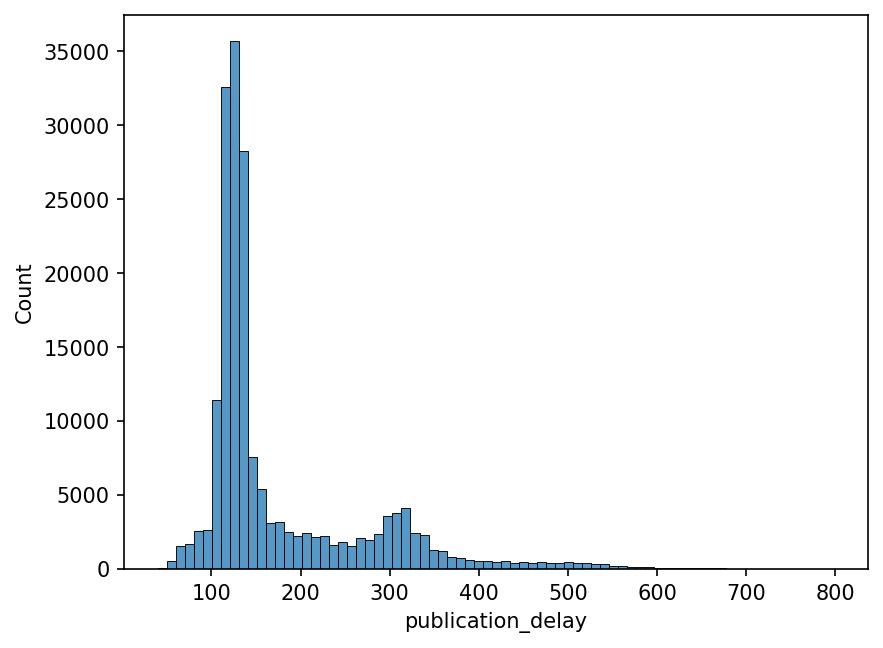

In [9]:
sns.histplot(df_pub_delay['publication_delay'], bins=75)
# Each bin is of size 759/bins = approx. 10 here

<Axes: xlabel='pub_delay_norm', ylabel='Count'>

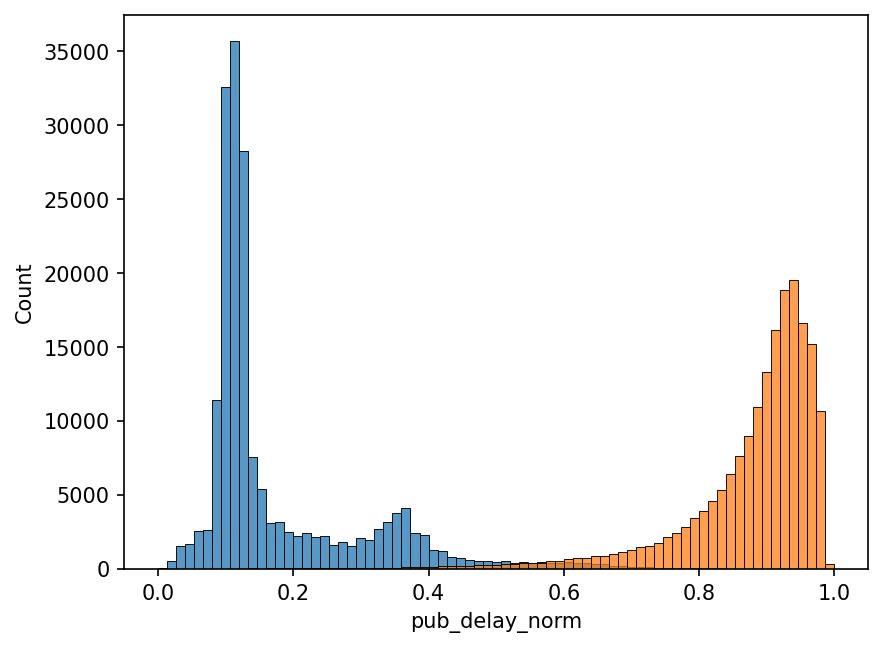

In [10]:
fig, ax = plt.subplots()
sns.histplot(df_pub_delay['pub_delay_norm'], bins=75)
sns.histplot(df_pub_delay['pred_prob_norm'], bins=75)

<Axes: xlabel='pub_delay_std', ylabel='Count'>

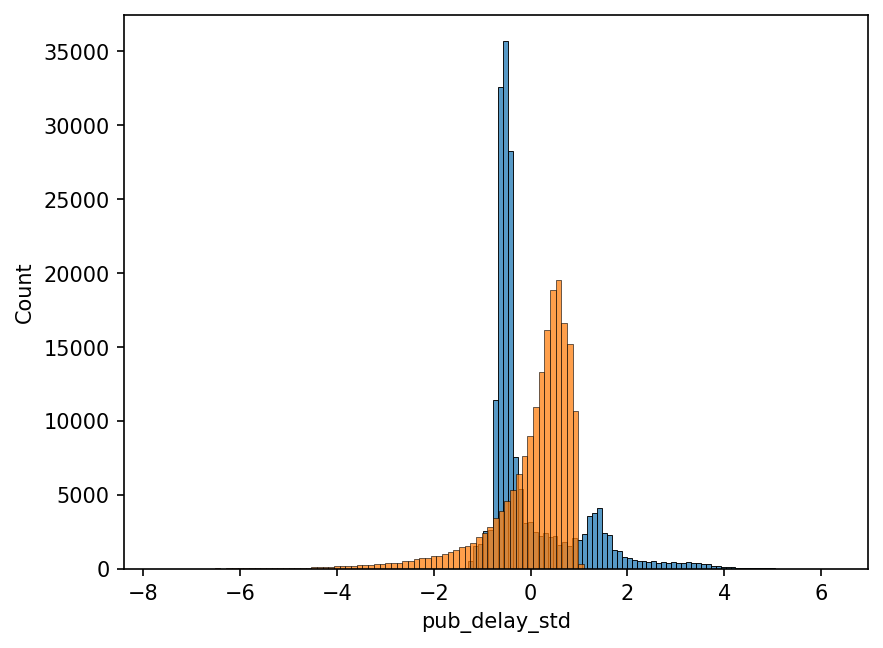

In [11]:
fig, ax = plt.subplots()
sns.histplot(df_pub_delay['pub_delay_std'], bins=75)
sns.histplot(df_pub_delay['pred_prob_std'], bins=75)

<Axes: xlabel='publication_delay', ylabel='pred_prob'>

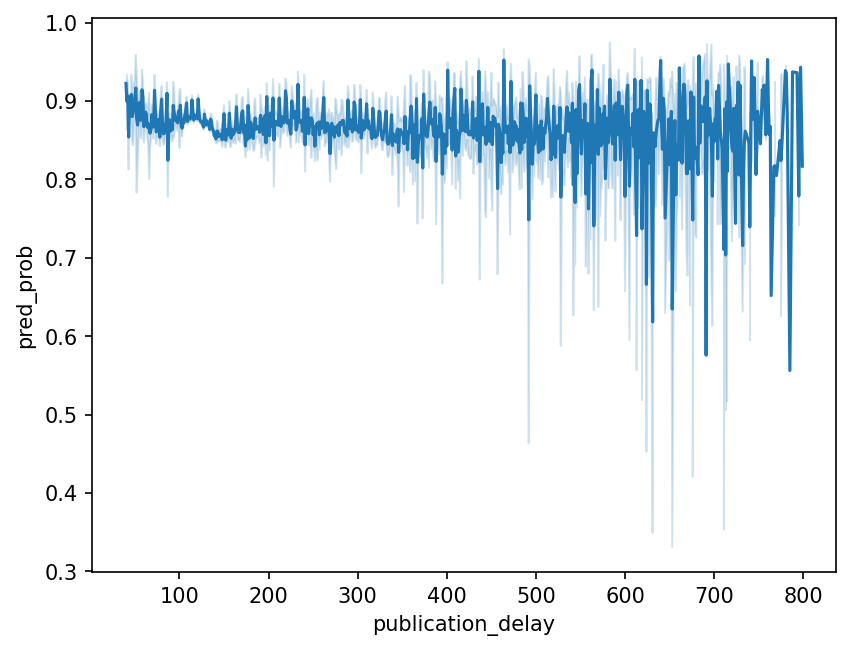

In [12]:
sns.lineplot(x=df_pub_delay['publication_delay'], y=df_pub_delay['pred_prob'])

In [13]:
def percentile_mean_plot(df, qnt=np.arange(0, 1.01, 0.1)):
  sns.set_theme()
  df['perc_pub_delay'] = pd.qcut(df["publication_delay"], q=qnt, duplicates='drop')
  df_avg = df[['pred_prob','perc_pub_delay','publication_delay']].groupby(by=['perc_pub_delay']).mean()
  plt.plot(df_avg['pred_prob'], df_avg['publication_delay'], '--o')
  plt.xlabel("Predicted Probability")
  plt.ylabel("Publication Delay")
  plt.title("Publication Delay vs Predicted Probability averaged over deciles")
  plt.show()

In [14]:
def percentile_mean_plot2(df, qnt=np.arange(0, 1.01, 0.1)):
  sns.set_theme()
  df['perc_prob'] = pd.qcut(df["pred_prob"], q=qnt, duplicates='drop')
  df_avg = df[['pred_prob','perc_prob','publication_delay']].groupby(by=['perc_prob']).mean()
  plt.plot(df_avg['pred_prob'], df_avg['publication_delay'], '--o')
  plt.xlabel("Predicted Probability")
  plt.ylabel("Publication Delay")
  plt.title("Publication Delay vs Predicted Probability averaged over deciles")
  plt.show()

In [15]:
def regplot(df):
  sns.set_theme()
  sns.regplot(x=np.log(df['publication_delay']), y=df['pred_prob'], x_bins=20)
  plt.ylabel("Predicted Probability")
  plt.xlabel("Publication Delay")
  plt.title("Regression Plot for Predicted Probability vs Publication Delay")
  plt.show()

<ipython-input-13-652f0421adce>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df[['pred_prob','perc_pub_delay','publication_delay']].groupby(by=['perc_pub_delay']).mean()


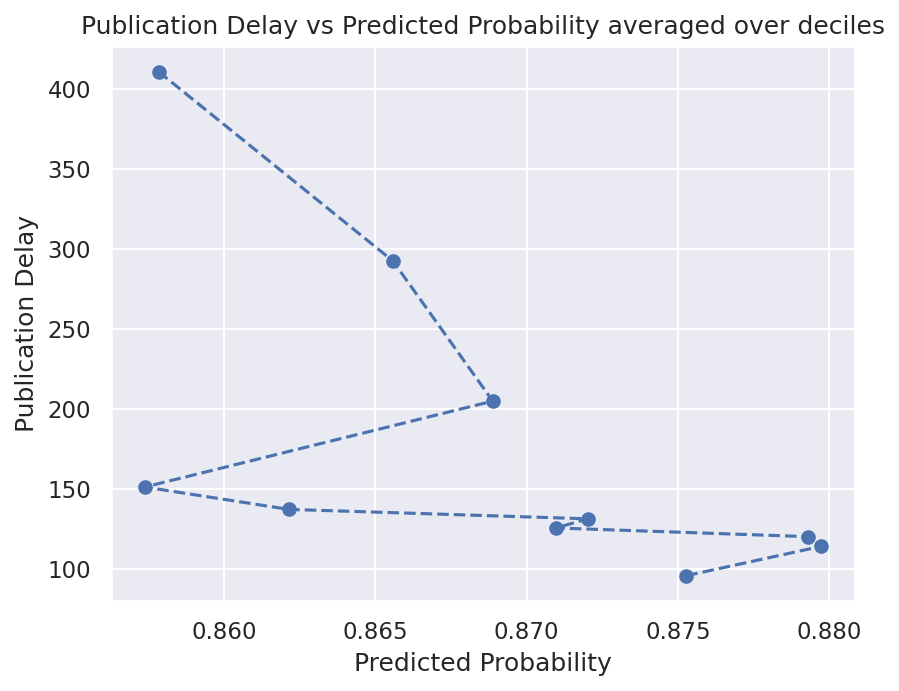

In [16]:
percentile_mean_plot(df_pub_delay)

<ipython-input-14-4938ec816e3e>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df[['pred_prob','perc_prob','publication_delay']].groupby(by=['perc_prob']).mean()


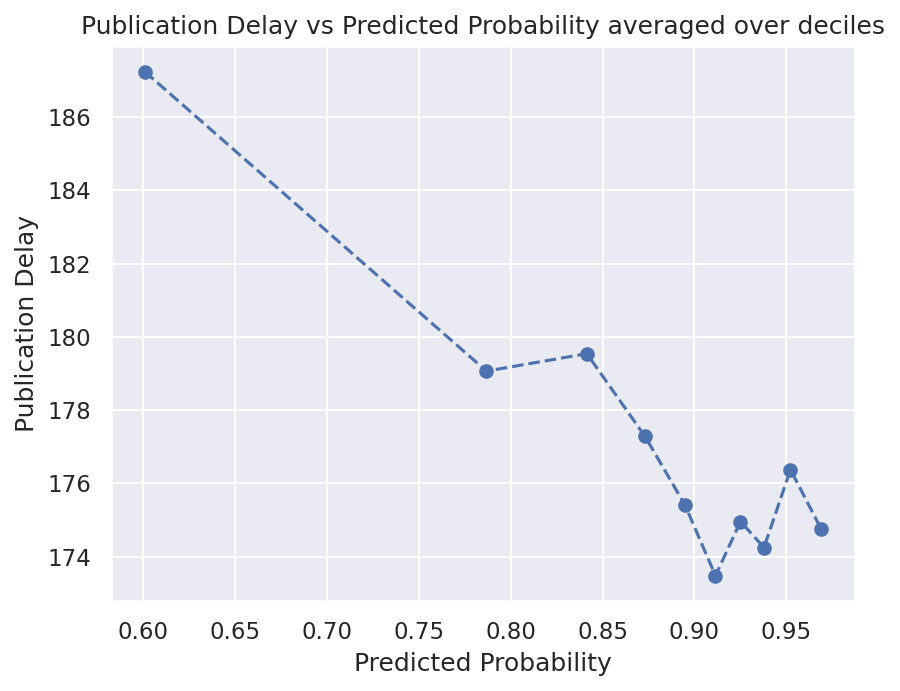

In [17]:
percentile_mean_plot2(df_pub_delay)

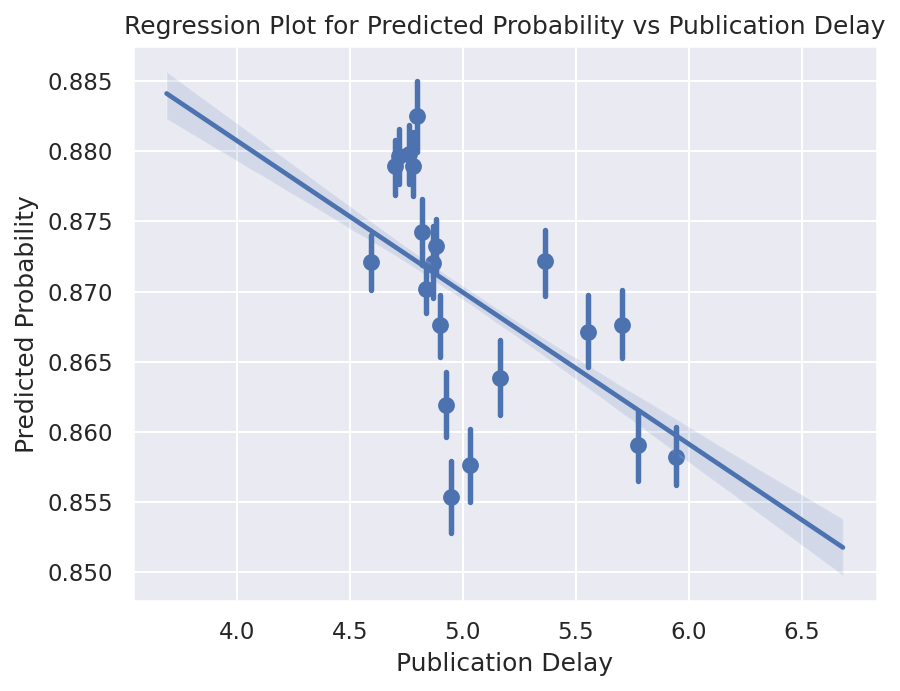

In [18]:
regplot(df_pub_delay)

### Only take probabilities > 0.5

(188649, 7)
(185121, 7)


<ipython-input-27-eb96b9d642d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perc_pub_delay'] = pd.qcut(df["publication_delay"], q=qnt, duplicates='drop')


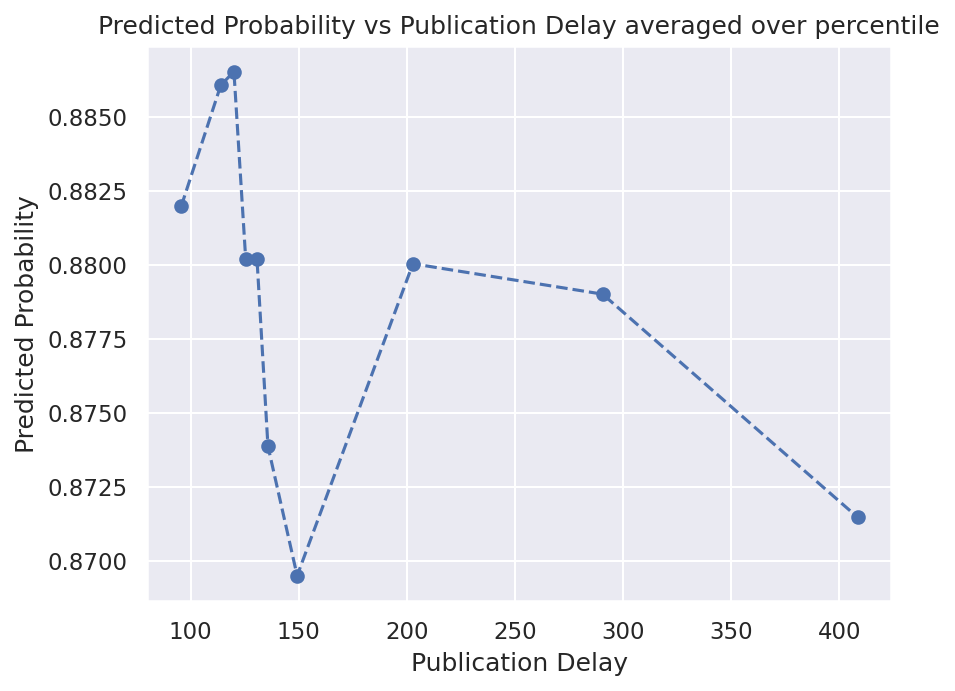

In [ ]:
df_pub_delay_great_half = df_pub_delay[df_pub_delay['pred_prob']>0.5]
print(df_pub_delay.shape)
print(df_pub_delay_great_half.shape)
percentile_mean_plot(df_pub_delay_great_half)

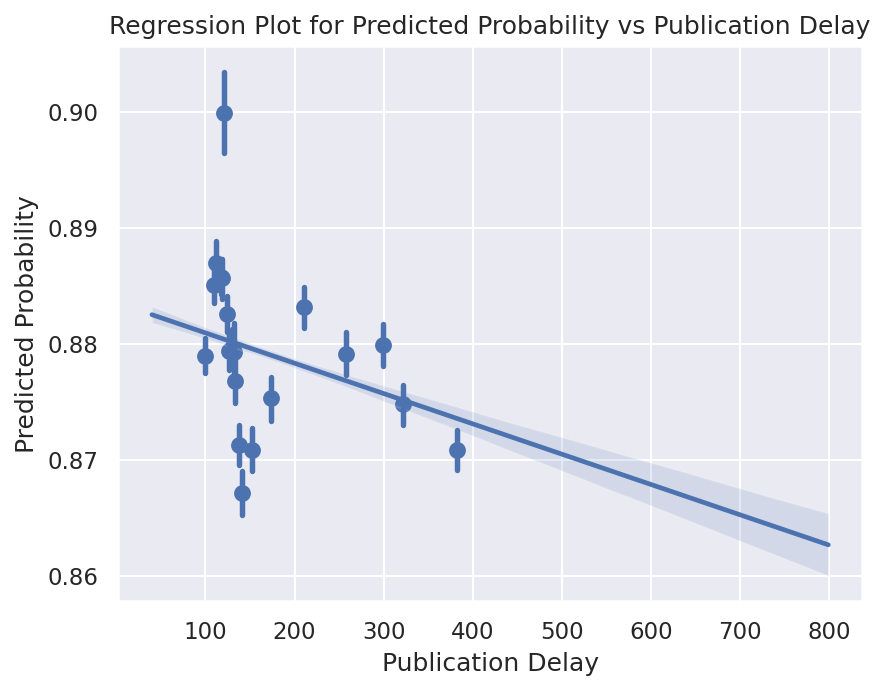

In [ ]:
regplot(df_pub_delay_great_half)

### Plot for Registration Delay

In [ ]:
# Get publication delay
df_probs['registration_delay'] = (df_probs['registration_dt'] - df_probs['filing_dt']).dt.days
df_reg_delay = df_probs[~df_probs['registration_delay'].isna()][['pred_prob','registration_delay']].copy()
df_reg_delay.head()

,pred_prob,registration_delay
4,0.751865,427.0
5,0.898656,399.0
7,0.968797,196.0
8,0.924783,196.0
9,0.921455,301.0


<Axes: xlabel='registration_delay', ylabel='Count'>

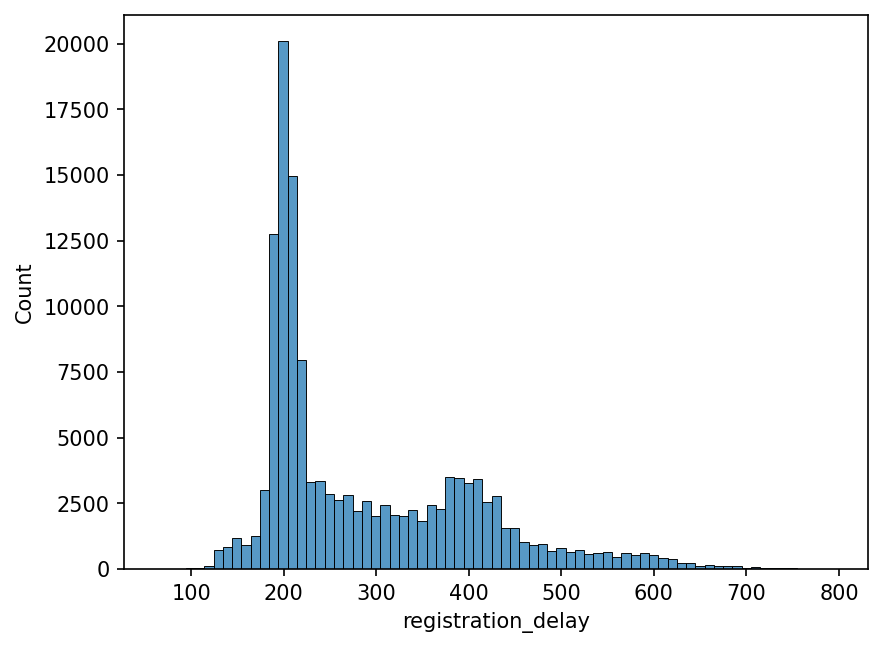

In [ ]:
# Each bin size = 10
nbins = int((df_reg_delay['registration_delay'].max() - df_reg_delay['registration_delay'].min())/10)

sns.histplot(df_reg_delay['registration_delay'], bins=nbins)


In [ ]:
# Get mean of pred_prob for each percentile bin
df_reg_delay['perc_reg_delay'] = pd.qcut(df_reg_delay["registration_delay"], q=np.arange(0, 1.01, 0.01), duplicates='drop')
df_reg_delay_avg = df_reg_delay[['pred_prob','perc_reg_delay','registration_delay']].groupby(by=['perc_reg_delay']).mean()


Text(0.5, 1.0, 'Predicted Probability vs Registration Delay averaged over percentile')

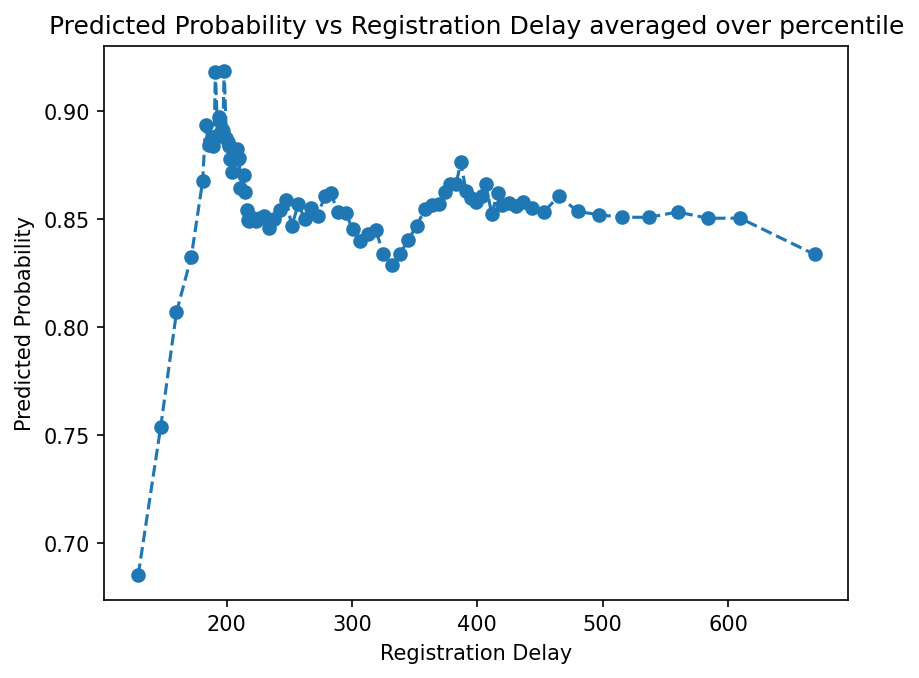

In [ ]:
plt.plot(df_reg_delay_avg['registration_delay'], df_reg_delay_avg['pred_prob'], '--o')
plt.ylabel("Predicted Probability")
plt.xlabel("Registration Delay")
plt.title("Predicted Probability vs Registration Delay averaged over percentile")